# Notes:

In this notebook, we analyze S&P 500 stock prices and fundamentals to identify potential pairs trading opportunities. The workflow involves:

1. Data Collection: Downloaded S&P 500 companies' historical prices and fundamental data.
2. Feature Engineering: Applied feature scaling to normalize data for clustering.
3. Dimensionality Reduction: Used Principal Component Analysis (PCA) to reduce feature dimensions while preserving key information.
4. Clustering with DBSCAN:
    - Grouped similar stocks into clusters based on fundamental and price data.
    - DBSCAN was chosen for its ability to detect arbitrary-shaped clusters and handle noise.

5.  Pairs Selection & Cointegration Testing:

- Within each identified cluster, stock pairs were tested for cointegration.
- Cointegrated pairs suggest potential mean-reverting relationships, making them ideal for statistical arbitrage.


Next Steps:
- Backtest the identified pairs to evaluate trading signals.
- Optimize feature selection to improve clustering quality.
- Explore additional machine learning models (e.g., HMM, k-Means) for refining clusters.

Outcome: The analysis provides a systematic approach to discovering stock pairs with strong statistical relationships, forming the foundation for an algorithmic pairs trading strategy.

# Import the libraries

In [ ]:
# For data manipulation and statistical tools
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

<a id='read'></a>
# Read the Data


In [ ]:
url_sp500 = 'https://raw.githubusercontent.com/Pipbytes/datasets/refs/heads/main/Time%20series/SP_500_data.csv'
url_fundamental = 'https://raw.githubusercontent.com/Pipbytes/datasets/refs/heads/main/Time%20series/fundamentals2.csv'

# Read data
price_data = pd.read_csv(url_sp500, index_col=0)
fundamentals_data = pd.read_csv(url_fundamental, index_col=0)

In [ ]:
price_data.head()

,A,AAP,AAPL,ABBV,ABC,ABMD,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XLNX,XOM,XRAY,XYL,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,85.017082,157.171890,74.096443,81.950539,82.634140,168.809998,204.910950,334.429993,116.506668,43.788410,...,142.405029,59.934875,100.115349,62.684341,56.203197,78.232391,147.579269,259.140015,49.560955,132.803421
2020-01-03,83.652077,157.181747,73.376083,81.172668,81.594910,166.820007,204.569687,331.809998,114.455727,43.702934,...,140.292755,60.223114,97.810677,62.180397,55.581242,78.692863,147.193512,256.049988,48.861588,132.823227
2020-01-06,83.899353,154.598541,73.960770,81.813271,82.789536,179.039993,203.233841,333.709991,113.111015,43.361061,...,140.015091,60.136642,95.771927,62.657814,55.887280,78.183411,146.342834,258.010010,48.266178,131.803482
2020-01-07,84.156532,152.764648,73.612930,81.346550,82.197075,180.350006,198.846008,333.390015,115.684357,42.838757,...,140.679504,60.011738,97.958405,62.145023,56.183449,77.889488,146.214264,256.470001,47.973186,132.248978
2020-01-08,84.987411,151.009644,74.797081,81.923080,82.993492,178.690002,199.236069,337.869995,116.729179,42.363934,...,141.562103,59.954086,97.682640,61.207855,56.775787,78.154007,147.965027,247.639999,48.445744,131.961884


In [ ]:
fundamentals_data.head()

,profitMargins,revenueGrowth,returnOnEquity,Sector,Industry
Symbol,,,,,
MMM,17.294000,9.6,47.467998,Industrials,Conglomerates
ABBV,10.278000,50.9,163.563990,Healthcare,Drug Manufacturers - General
ABMD,26.610002,16.7,18.832001,NaN,NaN
ACN,12.051000,20.7,32.209998,Technology,Information Technology Services
ATVI,26.957000,27.2,16.302000,NaN,NaN


# EDA

## Fundamentals

In [ ]:
fundamentals_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, MMM to ZTS
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   profitMargins   473 non-null    float64
 1   revenueGrowth   473 non-null    float64
 2   returnOnEquity  473 non-null    float64
 3   Sector          439 non-null    object 
 4   Industry        439 non-null    object 
dtypes: float64(3), object(2)
memory usage: 22.2+ KB


In [ ]:
fundamentals_data.describe()

,profitMargins,revenueGrowth,returnOnEquity
count,473.000000,473.000000,473.000000
mean,11.048799,70.618182,44.566222
std,22.958122,1108.425629,263.699990
min,-234.952000,-99.800000,-560.546000
25%,5.333000,2.800000,7.430000
50%,11.883000,12.200000,14.668000
75%,18.966000,27.200000,28.039000
max,151.726000,24112.500000,3835.340000


In [ ]:
fundamentals_data.describe(include='object')

,Sector,Industry
count,439,439
unique,11,108
top,Technology,Utilities - Regulated Electric
freq,65,22


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def sector_distribution(df, sector_name=None):
    # Filter dataset
    if sector_name:
        if sector_name not in df['Sector'].unique():
            raise ValueError(f"{sector_name} not found in the dataset.")
        else:
            df = df[df['Sector'] == sector_name]


    # Determine the column for distribution
    plot_col = "Industry" if sector_name else "Sector"

    # Define color palette based on unique values
    unique_count = df[plot_col].nunique()
    palette = sns.color_palette("viridis", n_colors=max(1, unique_count))  # Avoids errors when unique_count = 0

    # Plot Distribution (Fixed Warning)
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df[plot_col], order=df[plot_col].value_counts().index,
                  hue=df[plot_col], palette=palette, legend=False)  # Fix applied

    # Set Titles
    plt.title(f"Distribution of {plot_col}{f' in {sector_name}' if sector_name else ''}")
    plt.xlabel("Count")
    plt.ylabel(plot_col)
    plt.show()

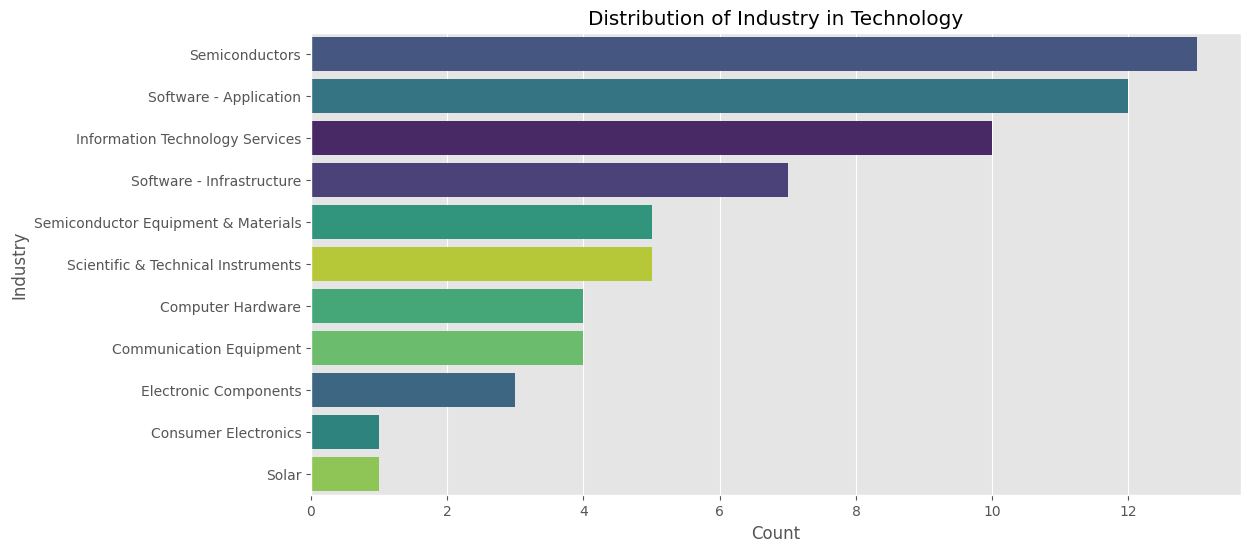

In [ ]:
sector_distribution(fundamentals_data, sector_name='Technology')

In [ ]:
def financial_metrics(df, metric, sector_name=None):
    if metric not in df.columns:
        raise ValueError(f"Column not found in the dataset.")

    # Filtering by specific sector
    if sector_name:
        if sector_name not in df["Sector"].unique():
            raise ValueError(f"Sector '{sector_name}' not found in the dataset.")
        df = df[df["Sector"] == sector_name]  # Fix: Correctly filter the dataset
        group_col = "Industry"  # When filtering by sector, group by Industry
    else:
        group_col = "Sector"  # Default grouping by Sector

    # Compute the mean financial metric per group
    metric_avg = df.groupby(group_col)[metric].mean().sort_values()

    # Plot
    plt.figure(figsize=(12, 6))
    metric_avg.plot(kind="barh", colormap="viridis")
    plt.title(f"Average {metric} by {group_col}{f' in {sector_name}' if sector_name else ''}")
    plt.xlabel(metric)
    plt.ylabel(group_col)
    plt.show()

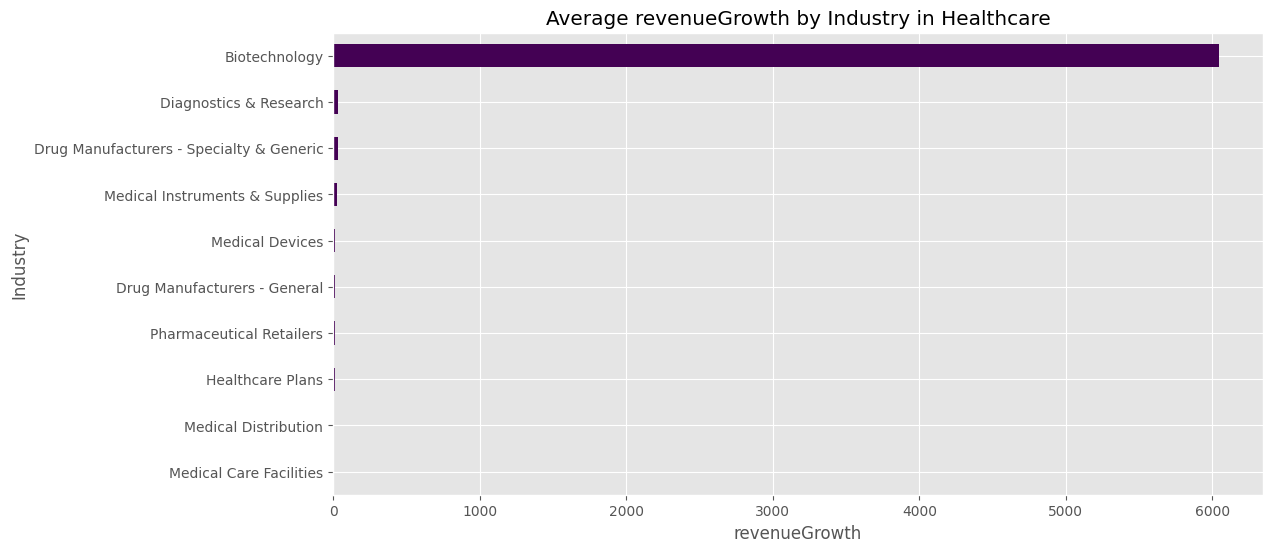

In [ ]:
financial_metrics(fundamentals_data, metric='revenueGrowth', sector_name='Healthcare')

# Data processing



## Price data

### Calculate returns

- compute stock return instead of using price because we need the data to be stationary.  



In [ ]:
# stock returns
returns = price_data.ffill().pct_change().dropna() # dates,features

### Dimension reduction with PCA

In [ ]:
from sklearn.decomposition import PCA

# PCA with n_components equal to the desired variance
desired_variance = 0.90
pca = PCA(n_components=desired_variance).fit(returns)

# Principal component vectors dataframe
pca_matrix = pca.components_ # pc_features by original_features
returns_pca = pd.DataFrame(pca_matrix.T, # transpose(pc, og) = og, pc
                           columns=["PC_" + str(i) for i in range(1, pca_matrix.shape[0]+1)],
                           index=returns.columns
                           )

In [ ]:
returns_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_69,PC_70,PC_71,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78
A,0.024513,0.047728,0.012189,0.011161,0.012913,-0.012946,-0.044103,0.029851,0.005108,0.043074,...,0.023357,0.014473,0.027339,0.024990,0.020820,-0.007978,0.014990,-0.012895,-0.022593,0.016875
AAP,0.036051,0.025795,-0.025765,-0.027625,-0.022082,0.002110,0.024286,-0.034958,-0.018286,-0.080817,...,-0.027004,0.015581,0.002094,-0.031044,-0.005729,0.035492,-0.010218,0.007201,0.004471,-0.001058
AAPL,0.023743,0.077581,0.027674,0.008564,0.026343,-0.017604,0.046218,-0.008045,-0.002363,-0.012450,...,-0.018649,-0.014389,-0.033826,-0.042536,-0.004396,0.016324,0.036073,-0.044519,0.019626,-0.013355
ABBV,0.018119,0.030860,-0.020158,0.033782,0.033787,0.019544,-0.018505,0.031679,-0.026793,0.011362,...,-0.042240,0.016368,0.051960,-0.009221,-0.082828,0.002874,-0.007810,0.040788,0.019352,-0.051413
ABC,0.029237,0.026735,-0.057144,0.023817,0.010492,-0.000674,0.011740,0.057613,-0.058520,0.022331,...,0.001938,-0.019397,-0.006259,0.020521,0.020482,0.005535,0.015096,-0.034337,-0.050567,0.005366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,0.042305,0.012578,-0.032099,0.001927,-0.042853,-0.021838,-0.032039,-0.011957,0.007568,-0.010937,...,-0.015027,-0.017927,0.019446,-0.028043,0.009075,0.062113,0.046595,0.032071,0.005375,-0.016719
ZBH,0.048835,0.011880,0.003084,-0.001796,0.053691,0.030774,-0.038543,-0.023006,-0.034037,0.047249,...,0.012385,-0.037579,0.031538,-0.040085,0.009207,-0.002733,-0.007077,-0.022397,0.017300,0.002698
ZBRA,0.037729,0.043955,0.030537,0.007445,-0.006784,-0.058407,-0.021682,0.001544,0.079376,0.007109,...,-0.003733,0.040732,0.032699,0.006164,-0.022107,0.072191,-0.097196,0.064497,0.116349,-0.015236
ZION,0.065537,-0.073111,-0.040511,0.024025,-0.011337,-0.131112,-0.051989,0.003889,-0.026072,0.076164,...,-0.031288,-0.037230,-0.003210,-0.034314,0.016445,-0.011143,-0.014614,0.015363,0.025921,-0.004038


### Feature scaling for returns

In [ ]:
# Scale returns dataset
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

returns_data_scaled = pd.DataFrame(sc.fit_transform(returns_pca),
                                   columns=returns_pca.columns,
                                   index=returns_pca.index,
                                   )


## Fundamental data

### Features encoding

- **OHE**: Does not work well with clustering cause `too sparse`, keeps categorical meaning but `high dimensionality`.

- **Label Encoding**: Does not work well with clustering because it `impose false and meaningless order`, but easy to interpret.

- **Frequency encoding**: Works well with clustering because it `compact and retain categorical importance` but loses `categorical meaning`.

- **Target encoding**: Works well with clustering because it `captures categorical relationships`, but `needs numerical features`.

#### OHE

In [ ]:
# OHE
ohe = pd.get_dummies(fundamentals_data.dropna(), columns=['Sector', 'Industry'], dtype=int)
ohe

,profitMargins,revenueGrowth,returnOnEquity,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,...,Industry_Tobacco,Industry_Tools & Accessories,Industry_Travel Services,Industry_Trucking,Industry_Utilities - Diversified,Industry_Utilities - Independent Power Producers,Industry_Utilities - Regulated Electric,Industry_Utilities - Regulated Gas,Industry_Utilities - Regulated Water,Industry_Waste Management
Symbol,,,,,,,,,,,,,,,,,,,,,
MMM,17.294,9.6,47.467998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABBV,10.278,50.9,163.563990,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ACN,12.051,20.7,32.209998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADBE,38.794,22.6,45.138000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMD,25.241,92.9,60.605000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,6.049,11.8,10.508000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZBRA,13.557,28.0,31.078000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZBH,8.009,3.6,4.680000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = fundamentals_data.copy().dropna()

# Initialize label encoders
sector_encoder = LabelEncoder()
industry_encoder = LabelEncoder()

le["Sector_Encoded"] = sector_encoder.fit_transform(le["Sector"])
le["Industry_Encoded"] = industry_encoder.fit_transform(le["Industry"])
le

,profitMargins,revenueGrowth,returnOnEquity,Sector,Industry,Sector_Encoded,Industry_Encoded
Symbol,,,,,,,
MMM,17.294,9.6,47.467998,Industrials,Conglomerates,7,22
ABBV,10.278,50.9,163.563990,Healthcare,Drug Manufacturers - General,6,29
ACN,12.051,20.7,32.209998,Technology,Information Technology Services,9,47
ADBE,38.794,22.6,45.138000,Technology,Software - Infrastructure,9,89
AMD,25.241,92.9,60.605000,Technology,Semiconductors,9,87
...,...,...,...,...,...,...,...
XYL,6.049,11.8,10.508000,Industrials,Specialty Industrial Machinery,7,93
ZBRA,13.557,28.0,31.078000,Technology,Communication Equipment,9,19
ZBH,8.009,3.6,4.680000,Healthcare,Medical Devices,6,59


#### Frequency encoding

In [ ]:
fe = fundamentals_data.copy().dropna()

# Frequency encoding
sector_freq = fe['Sector'].value_counts(normalize=True)
fe['Sector_encoded'] = fe['Sector'].map(sector_freq)

industry_freq = fe['Industry'].value_counts(normalize=True)
fe['Industry_encoded'] = fe['Industry'].map(industry_freq)
fe

,profitMargins,revenueGrowth,returnOnEquity,Sector,Industry,Sector_encoded,Industry_encoded
Symbol,,,,,,,
MMM,17.294,9.6,47.467998,Industrials,Conglomerates,0.143508,0.004556
ABBV,10.278,50.9,163.563990,Healthcare,Drug Manufacturers - General,0.127563,0.018223
ACN,12.051,20.7,32.209998,Technology,Information Technology Services,0.148064,0.022779
ADBE,38.794,22.6,45.138000,Technology,Software - Infrastructure,0.148064,0.015945
AMD,25.241,92.9,60.605000,Technology,Semiconductors,0.148064,0.029613
...,...,...,...,...,...,...,...
XYL,6.049,11.8,10.508000,Industrials,Specialty Industrial Machinery,0.143508,0.031891
ZBRA,13.557,28.0,31.078000,Technology,Communication Equipment,0.148064,0.009112
ZBH,8.009,3.6,4.680000,Healthcare,Medical Devices,0.127563,0.018223


#### Merging fundamental with encoded data

`pd.merge()`

- how=`'inner'` → Only keeps rows with matching values in both DataFrames.
- how=`'left'` → Keeps all rows from df1 and fills in missing values from df2 (if no match is found).
- how=`'right'` → Keeps all rows from df2 and fills in missing values from df1.
- how=`'outer'` → Keeps all rows from both DataFrames, filling missing values with NaN.

In [ ]:
encoded_cols = ['Sector_encoded', 'Industry_encoded']
fundamentals_encoded = pd.merge(fundamentals_data, fe[encoded_cols],
                                left_index=True,
                                right_index=True,
                                how='inner')
fundamentals_encoded.drop(columns=['Sector', 'Industry'], inplace=True)
fundamentals_encoded

,profitMargins,revenueGrowth,returnOnEquity,Sector_encoded,Industry_encoded
Symbol,,,,,
MMM,17.294,9.6,47.467998,0.143508,0.004556
ABBV,10.278,50.9,163.563990,0.127563,0.018223
ACN,12.051,20.7,32.209998,0.148064,0.022779
ADBE,38.794,22.6,45.138000,0.148064,0.015945
AMD,25.241,92.9,60.605000,0.148064,0.029613
...,...,...,...,...,...
XYL,6.049,11.8,10.508000,0.143508,0.031891
ZBRA,13.557,28.0,31.078000,0.148064,0.009112
ZBH,8.009,3.6,4.680000,0.127563,0.018223


### Feature scaling for fundamentals data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histograms(data, columns):
    # Set up subplots
    plt.figure(figsize=(18, 5))

    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data[col], kde=True, bins=30, color='steelblue')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


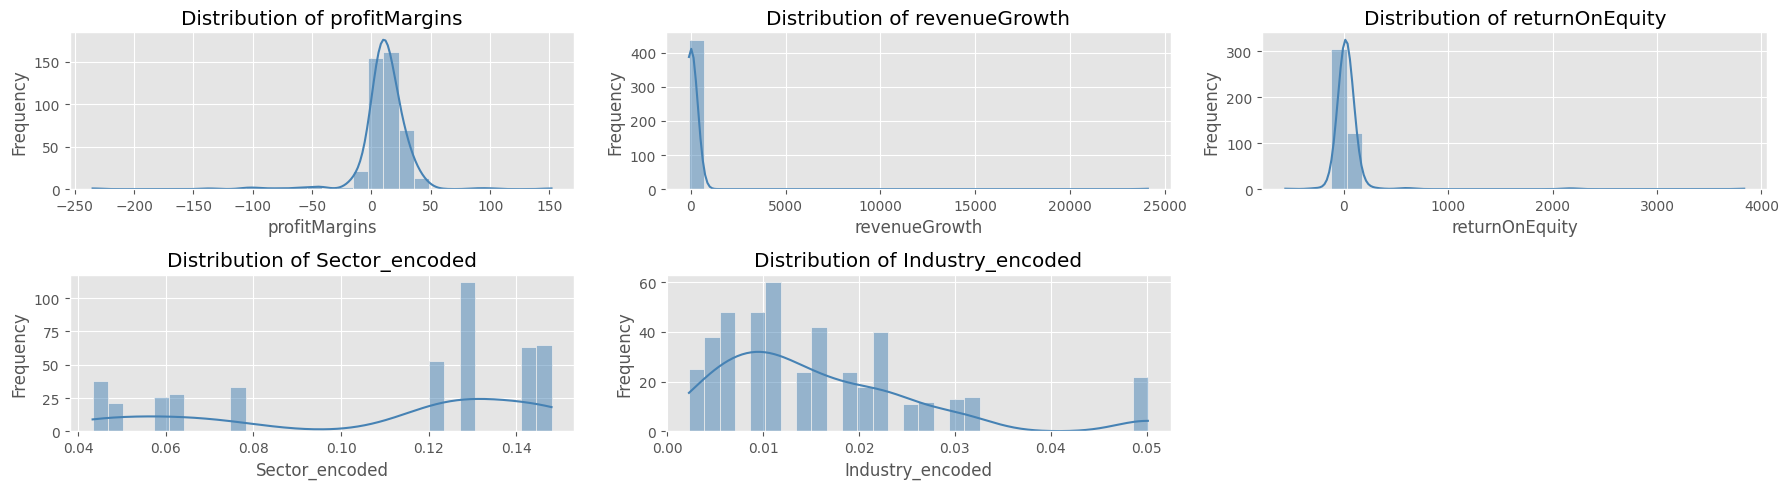

In [ ]:
plot_histograms(fundamentals_encoded, fundamentals_encoded.columns)

From the distribution plot, we can observe that the fundamentals data are skewed in positive and negative range.

We will use signal log transformation which handles +ve and -ve values safely, compresses extreme values, and preserves the sign.



In [ ]:
import numpy as np

def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Apply signed log transform to remove skeweness
cols = ['profitMargins', 'revenueGrowth', 'returnOnEquity']
fundamentals_data_tf = fundamentals_encoded[cols].apply(signed_log1p)

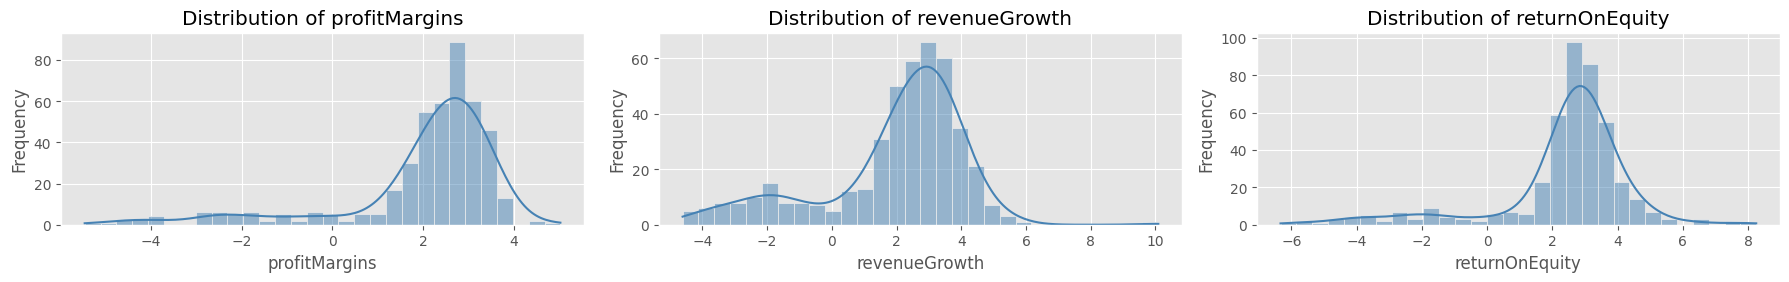

In [ ]:
plot_histograms(fundamentals_data_tf, fundamentals_data_tf.columns)

In [ ]:
sc2 = StandardScaler()
fundamentals_scaled = pd.DataFrame(sc2.fit_transform(fundamentals_data_tf),
                                   columns=fundamentals_data_tf.columns,
                                   index=fundamentals_data_tf.index,
                                   )
fundamentals_scaled.head()

,profitMargins,revenueGrowth,returnOnEquity
Symbol,,,
MMM,0.513366,0.193066,0.734970
ABBV,0.241727,0.908419,1.326421
ACN,0.323721,0.515717,0.552051
ADBE,0.949783,0.553516,0.711133
AMD,0.715951,1.175432,0.851015


### Merging encoded with scaled data

In [ ]:
encoded_cols = ['Sector_encoded', 'Industry_encoded']
fundamentals_scaled_encoded = pd.merge(fundamentals_scaled, fe[encoded_cols],
                                left_index=True,
                                right_index=True,
                                how='inner')
fundamentals_scaled_encoded

,profitMargins,revenueGrowth,returnOnEquity,Sector_encoded,Industry_encoded
Symbol,,,,,
MMM,0.513366,0.193066,0.734970,0.143508,0.004556
ABBV,0.241727,0.908419,1.326421,0.127563,0.018223
ACN,0.323721,0.515717,0.552051,0.148064,0.022779
ADBE,0.949783,0.553516,0.711133,0.148064,0.015945
AMD,0.715951,1.175432,0.851015,0.148064,0.029613
...,...,...,...,...,...
XYL,-0.022191,0.277996,0.039268,0.143508,0.031891
ZBRA,0.385048,0.646309,0.535271,0.148064,0.009112
ZBH,0.115582,-0.182879,-0.302371,0.127563,0.018223


## Merge Scaled Returns data with scaled transformed fundamental data

In [ ]:
X = returns_data_scaled.merge(fundamentals_scaled_encoded,
                              left_index=True,
                              right_index=True,
                              how='inner'
                              )
X.head()


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_74,PC_75,PC_76,PC_77,PC_78,profitMargins,revenueGrowth,returnOnEquity,Sector_encoded,Industry_encoded
A,-0.798170,0.728196,0.406469,0.193927,0.213681,-0.278796,-1.013349,0.543785,0.131408,0.958665,...,-0.157554,0.339460,-0.290966,-0.492390,0.365527,0.468923,0.564823,0.314245,0.127563,0.022779
AAP,-0.241226,0.217300,-0.426884,-0.650628,-0.549153,0.048669,0.476085,-0.874122,-0.377495,-1.736424,...,0.787983,-0.208829,0.146102,0.096209,-0.024483,-0.032807,0.568529,0.283239,0.120729,0.011390
AAPL,-0.835315,1.423575,0.746478,0.137382,0.506444,-0.380093,0.953738,-0.285309,-0.031109,-0.249204,...,0.371054,0.798020,-0.978784,0.425828,-0.291930,0.676275,0.931258,1.106237,0.148064,0.002278
ABBV,-1.106765,0.335284,-0.303775,0.686502,0.668700,0.427830,-0.455855,0.583775,-0.562534,0.268796,...,0.078500,-0.156450,0.876616,0.419853,-1.119642,0.241727,0.908419,1.326421,0.127563,0.018223
ACN,-0.260464,0.760490,-0.180587,0.211540,0.558523,-0.372574,-0.382605,0.168192,-0.653569,-0.416695,...,-0.758786,-1.049728,-0.383092,0.551736,0.140213,0.323721,0.515717,0.552051,0.148064,0.022779


In [ ]:
X2 = X.drop(columns=['Sector_encoded', 'Industry_encoded'])
X2.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_72,PC_73,PC_74,PC_75,PC_76,PC_77,PC_78,profitMargins,revenueGrowth,returnOnEquity
A,-0.798170,0.728196,0.406469,0.193927,0.213681,-0.278796,-1.013349,0.543785,0.131408,0.958665,...,0.553283,0.453515,-0.157554,0.339460,-0.290966,-0.492390,0.365527,0.468923,0.564823,0.314245
AAP,-0.241226,0.217300,-0.426884,-0.650628,-0.549153,0.048669,0.476085,-0.874122,-0.377495,-1.736424,...,-0.665427,-0.123906,0.787983,-0.208829,0.146102,0.096209,-0.024483,-0.032807,0.568529,0.283239
AAPL,-0.835315,1.423575,0.746478,0.137382,0.506444,-0.380093,0.953738,-0.285309,-0.031109,-0.249204,...,-0.915373,-0.094916,0.371054,0.798020,-0.978784,0.425828,-0.291930,0.676275,0.931258,1.106237
ABBV,-1.106765,0.335284,-0.303775,0.686502,0.668700,0.427830,-0.455855,0.583775,-0.562534,0.268796,...,-0.190786,-1.800684,0.078500,-0.156450,0.876616,0.419853,-1.119642,0.241727,0.908419,1.326421
ACN,-0.260464,0.760490,-0.180587,0.211540,0.558523,-0.372574,-0.382605,0.168192,-0.653569,-0.416695,...,-0.275530,-0.434708,-0.758786,-1.049728,-0.383092,0.551736,0.140213,0.323721,0.515717,0.552051


# Unsupervised ML

## Create Clusters with DBSCAN

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from itertools import combinations

def create_clusters(data, eps=5, samples=3, combine_df=None):
    # Instantiate and fit model
    dbscan = DBSCAN(eps=eps, min_samples=samples).fit(data)

    # Cluster labels in range(-1, n)
    labels = dbscan.labels_

    # Determine the number of clusters (ignoring noise), range(0, n)
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Create a Series mapping tickers to their cluster labels
    clustered_series_all = pd.Series(data=labels.flatten(), index=data.index) # a series of tickers by cluster_num in (-1, n)

    # Remove noise points (label = -1)
    clustered_series = clustered_series_all[clustered_series_all != -1]

    # Generate stock pairs for each cluster
    cluster_pairs = []
    stock_pairs_list = []

    for cluster in range(n_clusters_):
        # Get all tickers in the current cluster
        cluster_tickers = clustered_series[clustered_series == cluster].index

        # Generate all possible pairs of tickers in the cluster
        pairs = list(combinations(cluster_tickers, 2))

        # Append results to list
        cluster_pairs.append({
            'Cluster No.': cluster,
            'Pairs': pairs,
            'Number of Pairs': len(pairs)
        })

        if combine_df is not None:
            for stock1, stock2 in pairs:
                stock_pairs_list.append({'stock1':stock1,
                                         'stock2':stock2,
                                         'cluster':cluster})
    if combine_df is not None:
        return pd.DataFrame(stock_pairs_list)

    return pd.DataFrame(cluster_pairs)

In [ ]:
stock_pairs_df = create_clusters(X, combine_df=True)
stock_pairs_df.head()

,stock1,stock2,cluster
0,AEE,AEP,0
1,AEE,ATO,0
2,AEE,AWK,0
3,AEE,CMS,0
4,AEE,DUK,0


In [ ]:
stock_pairs_df['cluster'].value_counts()

,count
cluster,
0,105
3,91
4,15
1,10
2,6
5,3


In [ ]:
stock_pairs_df['cluster'].sum()

np.int64(370)

## Check for cointegration

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def check_cointegration(pairs_df, price_df, significant_level=0.05):
    results = []  # List to store results

    for _, row in pairs_df.iterrows():
        stock1, stock2, cluster = row["stock1"], row["stock2"], row["cluster"]

        try:
            # Get stock price time series
            series1 = price_df[stock1].dropna()
            series2 = price_df[stock2].dropna()

            # Align time series
            common_index = series1.index.intersection(series2.index)
            y = series1.loc[common_index]
            x = series2.loc[common_index]

            if len(y) == 0 or len(x) == 0:
                results.append([stock1, stock2, cluster, None])  # Not enough data
                continue

            # OLS Regression to find hedge ratio
            x = sm.add_constant(x)  # Add intercept term
            model = sm.OLS(y, x).fit()
            hedge_ratio = model.params.iloc[-1]  # Use .iloc to avoid FutureWarning

            # Compute spread (residuals)
            residuals = y - hedge_ratio * x.iloc[:, 1]

            # ADF test on residuals
            adf_result = adfuller(residuals)
            p_value = adf_result[1]

            # Cointegrated if p-value < significant_level
            cointegrated = p_value < significant_level
            results.append([stock1, stock2, cluster, cointegrated])

        except KeyError:
            # If stock not found in price_df, return None
            results.append([stock1, stock2, cluster, None])

    # Convert results into a DataFrame
    cointegration_df = pd.DataFrame(results, columns=["stock1", "stock2", "cluster", "cointegrated"])

    return cointegration_df


In [ ]:
tradeable_pairs = check_cointegration(stock_pairs_df, price_data)

In [ ]:
tradeable_pairs[tradeable_pairs['cointegrated']==True]

,stock1,stock2,cluster,cointegrated
8,AEE,LNT,0,True
15,AEP,AWK,0,True
20,AEP,ETR,0,True
23,AEP,PNW,0,True
27,ATO,AWK,0,True
34,ATO,NI,0,True
53,CMS,ETR,0,True
58,CMS,WEC,0,True
70,ED,ETR,0,True
77,ES,ETR,0,True


In [ ]:
tradeable_pairs[tradeable_pairs['cointegrated']==True]['cointegrated'].sum()

np.int64(34)

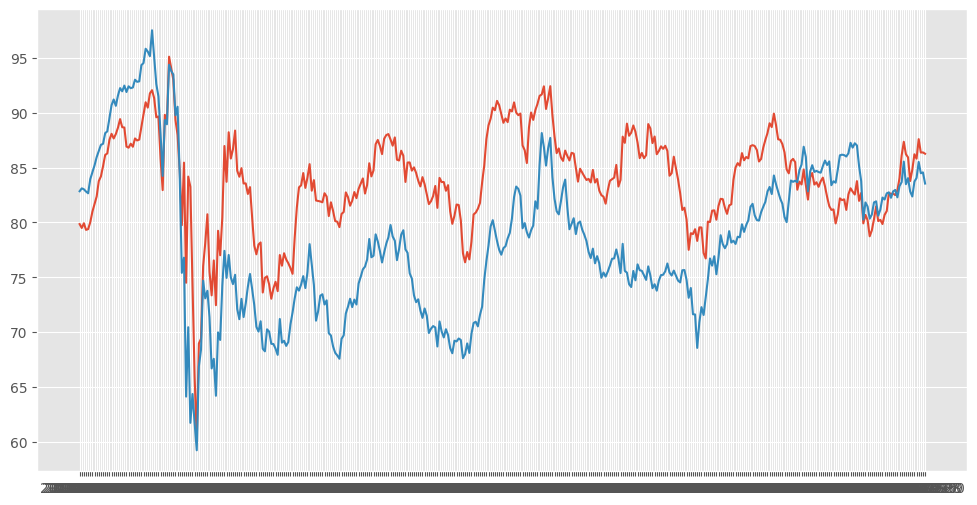

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(price_data['ES'].index, price_data['ES'], label='ES')
plt.plot(price_data['PNW'].index, price_data['PNW'], label='PNW')

In [ ]:
stock_pairs_df2 = create_clusters(X2, combine_df=True)
tradeable_pairs2 = check_cointegration(stock_pairs_df2, price_data)
tradeable_pairs2[tradeable_pairs2['cointegrated']==True]['cointegrated'].sum()

np.int64(34)